In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/land-cover-classification-master')

In [ ]:
!pip install tensorflow rasterio numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 92.4 MB/s eta 0:00:00


## Splitting the dataset into training,validation and testing sets and then training the model

In [ ]:
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
import pickle

# Define dataset file paths
dataset_path = "/content/drive/MyDrive/land-cover-classification-master/data/19920612_AVIRIS_IndianPine_Site3.tif"
ground_truth_path = "/content/drive/MyDrive/land-cover-classification-master/data/19920612_AVIRIS_IndianPine_Site3_gr.tif"

# Load Hyperspectral Image (220 bands)
with rasterio.open(dataset_path) as src:
    image = src.read()  # Shape: (220, H, W)

# Load Ground Truth Labels
with rasterio.open(ground_truth_path) as src:
    labels = src.read(1)  # Shape: (H, W)

# Transpose image from (Bands, Height, Width) → (Height, Width, Bands)
image = np.transpose(image, (1, 2, 0))

# 1️⃣ **Standardization Instead of Min-Max Normalization**
def standardize_image(image):
    scaler = StandardScaler()
    h, w, bands = image.shape
    image = image.reshape(-1, bands)  # Flatten to (pixels, bands)
    image = scaler.fit_transform(image)  # Standardize
    return image.reshape(h, w, bands)  # Reshape back

image = standardize_image(image)

# 2️⃣ **Dimensionality Reduction (PCA - Optional)**
def apply_pca(image, num_components=50):
    h, w, bands = image.shape
    image_reshaped = image.reshape(-1, bands)
    pca = PCA(n_components=num_components)
    image_pca = pca.fit_transform(image_reshaped)
    return image_pca.reshape(h, w, num_components)

NUM_COMPONENTS = 50
image = apply_pca(image, num_components=NUM_COMPONENTS)

# Define patch size
PATCH_SIZE = 5

# 3️⃣ **Patch Extraction**
def extract_patches(image, labels, patch_size):
    half_patch = patch_size // 2
    h, w, bands = image.shape
    X, y = [], []

    for i in range(half_patch, h - half_patch):
        for j in range(half_patch, w - half_patch):
            if labels[i, j] > 0:  # Ignore unlabeled pixels (background)
                patch = image[i - half_patch:i + half_patch + 1, j - half_patch:j + half_patch + 1, :]
                X.append(patch)
                y.append(labels[i, j] - 1)

    return np.array(X), np.array(y)

X, y = extract_patches(image, labels, PATCH_SIZE)

# 4️⃣ **Convert labels to one-hot encoding**
NUM_CLASSES = 17
y = to_categorical(y, NUM_CLASSES)

# 5️⃣ **Split into Train (70%), Validation (15%), and Test (15%) sets**
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Further split temp set into Validation (50%) and Test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 6️⃣ **Data Augmentation for Training & Validation Sets**
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

# Apply augmentation using `tf.data.Dataset`
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y)).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)  # No augmentation for validation

# 7️⃣ **Save Test Set for Future Use**
with open("/content/drive/MyDrive/land-cover-classification-master/test_data.pkl", "wb") as f:
    pickle.dump((X_test, y_test), f)

# Final Data Shape Summary
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Train shape: (7136, 5, 5, 50), Validation shape: (1529, 5, 5, 50), Test shape: (1530, 5, 5, 50)


In [ ]:
import tensorflow as tf
from LULC_CNN_TF import LULC_CNN

# Initialize Model
NUM_COMPONENTS = 50  # This is defined in your preprocessing step

cnn_model = LULC_CNN(
    input_shape=(PATCH_SIZE, PATCH_SIZE, NUM_COMPONENTS),  # Use NUM_COMPONENTS from PCA
    n_classes=NUM_CLASSES,
    learning_rate=0.001,
    batch_size=32,
    epochs=100
)


# Print model summary
cnn_model.model.summary()

# Define Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train Model (Only Training & Validation sets)
history = cnn_model.fit(X_train, y_train, X_val=X_val, y_val=y_val, callbacks=[early_stopping, reduce_lr])

# Save the trained model
cnn_model.save_model("/content/drive/MyDrive/land-cover-classification-master/2D_CNN_updated.h5")

print("Training complete. Model saved.")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 5, 5, 32)            │          14,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 5, 5, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 17)                  │          17,425 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,041 (457.19 KB)

 Trainable params: 116,977 (456.94 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5593 - loss: 1.2922 - val_accuracy: 0.9026 - val_loss: 0.2838 - learning_rate: 0.0010
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9375 - loss: 0.1929 - val_accuracy: 0.9666 - val_loss: 0.0993 - learning_rate: 0.0010
Epoch 3/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9769 - loss: 0.0735 - val_accuracy: 0.9817 - val_loss: 0.0624 - learning_rate: 0.0010
Epoch 4/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9878 - loss: 0.0453 - val_accuracy: 0.9823 - val_loss: 0.0505 - learning_rate: 0.0010
Epoch 5/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9896 - loss: 0.0351 - val_accuracy: 0.9784 - val_loss: 0.0746 - learning_rate: 0.0010
Epoch 6/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9925 - loss: 0.0212 - val_accuracy: 0.9765 - val_loss: 0.0675 - learning_rate: 0.0010
Epoch 7/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9912 - loss: 0.

Training complete. Model saved.


In [ ]:
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
import pickle

# Load dataset
dataset_path = "/content/drive/MyDrive/land-cover-classification-master/data/19920612_AVIRIS_IndianPine_Site3.tif"
ground_truth_path = "/content/drive/MyDrive/land-cover-classification-master/data/19920612_AVIRIS_IndianPine_Site3_gr.tif"

with rasterio.open(dataset_path) as src:
    image = src.read()  # Shape: (220, H, W)

with rasterio.open(ground_truth_path) as src:
    labels = src.read(1)  # Shape: (H, W)

image = np.transpose(image, (1, 2, 0))  # (H, W, Bands)

# **Standardization Instead of Min-Max Normalization**
scaler = StandardScaler()
h, w, bands = image.shape
image = scaler.fit_transform(image.reshape(-1, bands)).reshape(h, w, bands)

# **PCA for Dimensionality Reduction**
NUM_COMPONENTS = 30  # Reduced from 50 to 30 for efficiency
pca = PCA(n_components=NUM_COMPONENTS)
image = pca.fit_transform(image.reshape(-1, bands)).reshape(h, w, NUM_COMPONENTS)

PATCH_SIZE = 5  # Adjusted patch size

# **Patch Extraction**
def extract_patches(image, labels, patch_size):
    half_patch = patch_size // 2
    h, w, bands = image.shape
    X, y = [], []

    for i in range(half_patch, h - half_patch):
        for j in range(half_patch, w - half_patch):
            if labels[i, j] > 0:  # Ignore unlabeled pixels
                patch = image[i - half_patch:i + half_patch + 1, j - half_patch:j + half_patch + 1, :]
                X.append(patch)
                y.append(labels[i, j] - 1)

    return np.array(X), np.array(y)

X, y = extract_patches(image, labels, PATCH_SIZE)

# Convert labels to categorical
NUM_CLASSES = 17
y = to_categorical(y, NUM_CLASSES)

# **Split into Train (70%), Validation (15%), and Test (15%)**
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# **Data Augmentation**
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2),
])

# Augment training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

# Save test data for later evaluation
with open("/content/drive/MyDrive/land-cover-classification-master/test_data.pkl", "wb") as f:
    pickle.dump((X_test, y_test), f)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Train: (7136, 5, 5, 30), Validation: (1529, 5, 5, 30), Test: (1530, 5, 5, 30)


In [ ]:
import tensorflow as tf
from LULC_CNN_TF import LULC_CNN

cnn_model = LULC_CNN(
    input_shape=(PATCH_SIZE, PATCH_SIZE, NUM_COMPONENTS),
    n_classes=NUM_CLASSES,
    learning_rate=0.0005,
    batch_size=32,
    epochs=75
)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# Train Model
history = cnn_model.fit(X_train, y_train, X_val=X_val, y_val=y_val, callbacks=[early_stopping, reduce_lr])

# Save Model
cnn_model.save_model("/content/drive/MyDrive/land-cover-classification-master/2D_CNN_final_model.h5")


Epoch 1/75
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.4895 - loss: 1.5552 - val_accuracy: 0.7639 - val_loss: 0.6625 - learning_rate: 5.0000e-04
Epoch 2/75
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7836 - loss: 0.5796 - val_accuracy: 0.8463 - val_loss: 0.4033 - learning_rate: 5.0000e-04
Epoch 3/75
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9067 - loss: 0.2766 - val_accuracy: 0.8803 - val_loss: 0.3215 - learning_rate: 5.0000e-04
Epoch 4/75
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9437 - loss: 0.1642 - val_accuracy: 0.9307 - val_loss: 0.1948 - learning_rate: 5.0000e-04
Epoch 5/75
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9725 - loss: 0.0970 - val_accuracy: 0.9457 - val_loss: 0.1695 - learning_rate: 5.0000e-04
Epoch 6/75
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9827 - loss: 0.0550 - val_accuracy: 0.9523 - val_loss: 0.1400 - learning_rate: 5.0000e-04
Epoch 7/75
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
✅ Test Accuracy: 98.63%

🔍 Classification Report:
              precision    recall  f1-score   support

     Class 1       1.00      0.88      0.93         8
     Class 2       0.99      0.99      0.99       215
     Class 3       1.00      0.99      1.00       117
     Class 4       0.94      0.97      0.96        35
     Class 5       0.99      0.99      0.99        71
     Class 6       0.98      1.00      0.99       112
     Class 7       1.00      1.00      1.00         4
     Class 8       1.00      1.00      1.00        74
     Class 9       1.00      0.67      0.80         3
    Class 10       0.98      0.98      0.98       145
    Class 11       0.99      0.98      0.99       364
    Class 12       0.98      0.99      0.98        92
    Class 13       1.00      1.00      1.00        32
    Class 14       0.99      0.99      0.99       194
    Class 15       0.94      0.98      0.96        50
    Class 16       1.00      1.00      1.00  

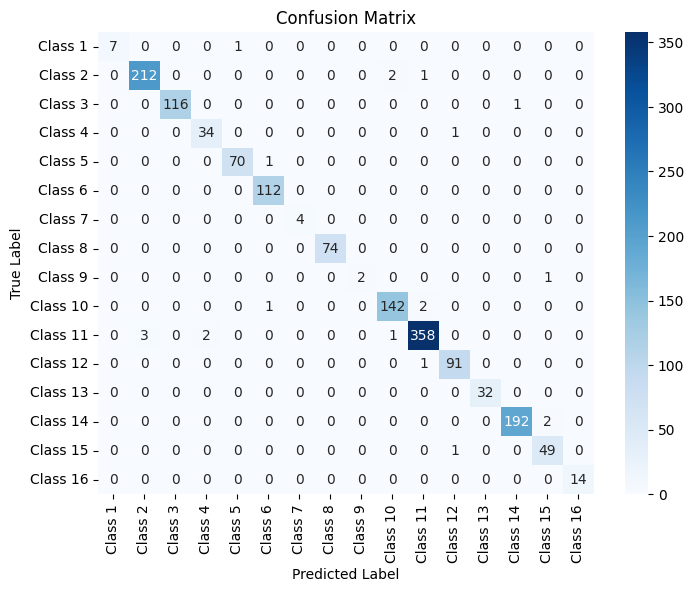

In [ ]:
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/land-cover-classification-master/2D_CNN_final_model.h5")

# Load test dataset (preprocessed & saved earlier)
test_data_path = "/content/drive/MyDrive/land-cover-classification-master/test_data.pkl"
with open(test_data_path, "rb") as f:
    X_test, y_test = pickle.load(f)

# Ensure proper reshaping & preprocessing
X_test_processed = X_test  # Already preprocessed (Standardized & PCA applied)
y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot labels to class indices

# Make predictions
y_pred_probs = model.predict(X_test_processed)  # Get probability scores
y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Convert softmax outputs to class labels

# Evaluate accuracy
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")

# Determine actual number of classes
unique_classes = np.unique(y_test_labels)
num_classes = len(unique_classes)

# Create correct target names
class_names = [f"Class {i+1}" for i in range(num_classes)]  # Now matches actual classes

# Show classification report
print("\n🔍 Classification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()